In [1]:
import matplotlib.pyplot as plt
import numpy as np
from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
import obspy
from obspy.clients.fdsn import Client

client = Client("IRIS")

def waveforms(start, end, adjtime):
    st = client.get_waveforms("XB", "ELYSE", "02", "B*", start-adjtime, end+adjtime)
    st.detrend(type='simple')
    return st

def uvw2enz(st):
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU), np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])

    return stENZ

In [2]:
def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

# S0235b

In [3]:
begin = UTCDateTime('2019-07-26T12:19:18')  # p-wave arrival
end = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-07-26T12:09:18.009000Z - 2019-07-26T12:32:04.959000Z | 20.0 Hz, 27340 samples
XB.ELYSE.02.BHN | 2019-07-26T12:09:18.009000Z - 2019-07-26T12:32:04.959000Z | 20.0 Hz, 27340 samples
XB.ELYSE.02.BHZ | 2019-07-26T12:09:18.009000Z - 2019-07-26T12:32:04.959000Z | 20.0 Hz, 27340 samples

In [4]:
stP = stf.slice(starttime=begin-1,endtime=begin+2)
stS = stf.slice(starttime=end-5, endtime=end+15)
print(stP)
print(stS)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-07-26T12:19:17.009000Z - 2019-07-26T12:19:20.009000Z | 20.0 Hz, 61 samples
XB.ELYSE.02.BHN | 2019-07-26T12:19:17.009000Z - 2019-07-26T12:19:20.009000Z | 20.0 Hz, 61 samples
XB.ELYSE.02.BHZ | 2019-07-26T12:19:17.009000Z - 2019-07-26T12:19:20.009000Z | 20.0 Hz, 61 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-07-26T12:22:00.009000Z - 2019-07-26T12:22:20.009000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHN | 2019-07-26T12:22:00.009000Z - 2019-07-26T12:22:20.009000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHZ | 2019-07-26T12:22:00.009000Z - 2019-07-26T12:22:20.009000Z | 20.0 Hz, 401 samples


In [5]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_74 = tval[np.where(alpha == 74)]
print(mina_74, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

#reported as 74

[ 0.08934134] [ 0.08880175]
optimal angle =  72  or  -108


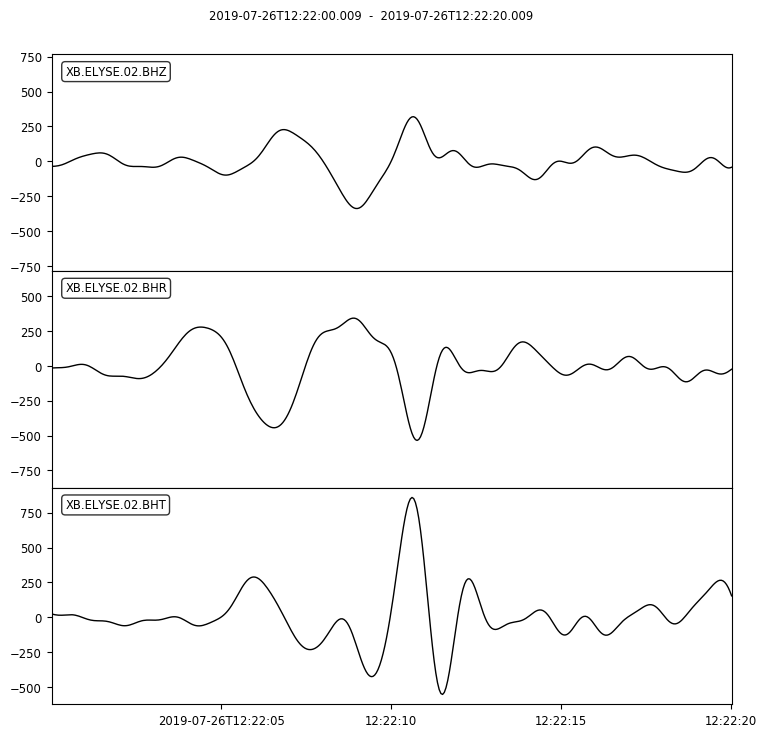

In [6]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,252)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0173a

In [7]:
begin = UTCDateTime('2019-05-23T02:22:59')  # p-wave arrival
end = UTCDateTime('2019-05-23T02:25:53')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)
    
stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHN | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples

In [8]:
stP = stf.slice(starttime=begin-1,endtime=begin+8)
stS = stf.slice(starttime=end-5, endtime=end+15)
print(stP)
print(stS)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:22:57.981000Z - 2019-05-23T02:23:06.981000Z | 20.0 Hz, 181 samples
XB.ELYSE.02.BHN | 2019-05-23T02:22:57.981000Z - 2019-05-23T02:23:06.981000Z | 20.0 Hz, 181 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:22:57.981000Z - 2019-05-23T02:23:06.981000Z | 20.0 Hz, 181 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:25:47.981000Z - 2019-05-23T02:26:07.981000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHN | 2019-05-23T02:25:47.981000Z - 2019-05-23T02:26:07.981000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:25:47.981000Z - 2019-05-23T02:26:07.981000Z | 20.0 Hz, 401 samples


In [9]:
scale = 1/400
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_91 = tval[np.where(alpha == 91)]
print(mina_91, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

#reported 91 degrees

[ 0.49613583] [ 0.44164387]
optimal angle =  86  or  -94


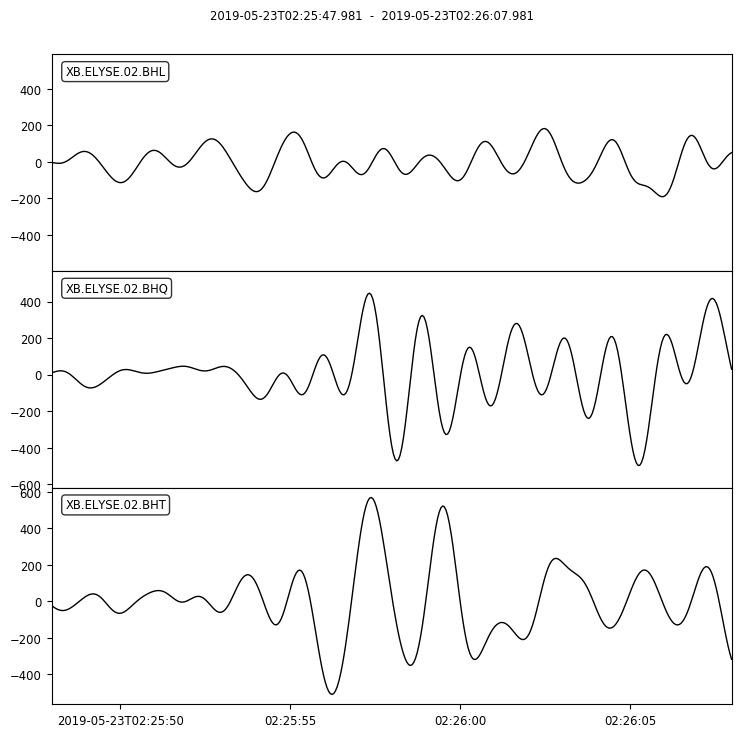

In [10]:
hhe = stS[0].data
hhn = stS[1].data
hhz = stS[2].data
hhT,hhR = rotate(hhe,hhn,266)

#incidence angle at the source from the ray param = the angle
hhQ,hhL = rotate(hhR,hhz,40)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhQ
streamRT[2].data = hhL
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'Q'
streamRT[2].stats.component = 'L'

streamRT.plot();

# S0325a

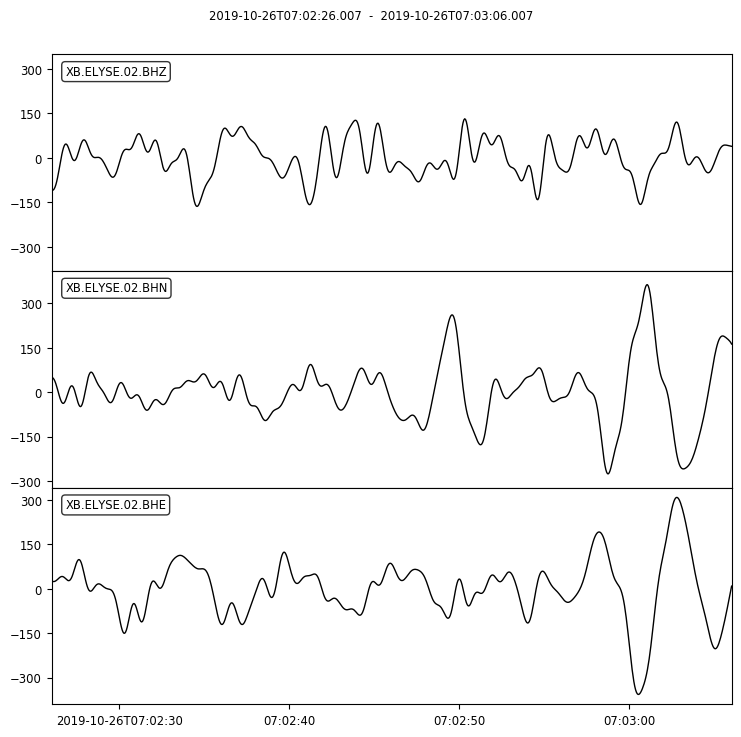

In [11]:
begin = UTCDateTime('2019-10-26T06:58:57')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:02:46')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stzoom = stf.slice(starttime=end-20, endtime=end+20)
stzoom.plot();

In [12]:
stP = stf.slice(starttime=begin-1,endtime=begin+3)
stS = stf.slice(starttime=end-5, endtime=end+15)
print(stP)
print(stS)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T06:58:56.007000Z - 2019-10-26T06:59:00.007000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHN | 2019-10-26T06:58:56.007000Z - 2019-10-26T06:59:00.007000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHZ | 2019-10-26T06:58:56.007000Z - 2019-10-26T06:59:00.007000Z | 20.0 Hz, 81 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T07:02:41.007000Z - 2019-10-26T07:03:01.007000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHN | 2019-10-26T07:02:41.007000Z - 2019-10-26T07:03:01.007000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHZ | 2019-10-26T07:02:41.007000Z - 2019-10-26T07:03:01.007000Z | 20.0 Hz, 401 samples


In [13]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[ 0.52475906]
optimal angle =  303  or  123


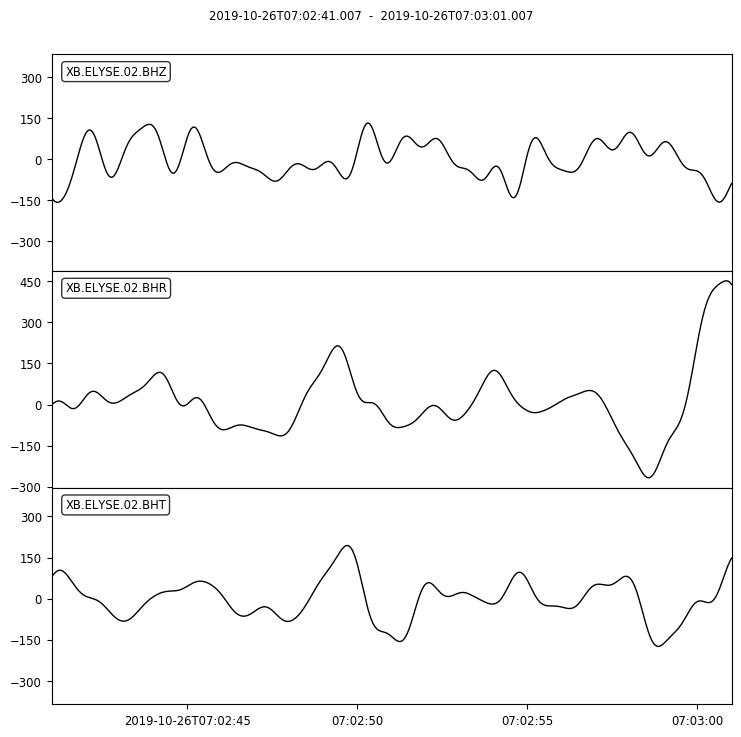

In [14]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,303)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();

# S0325ab

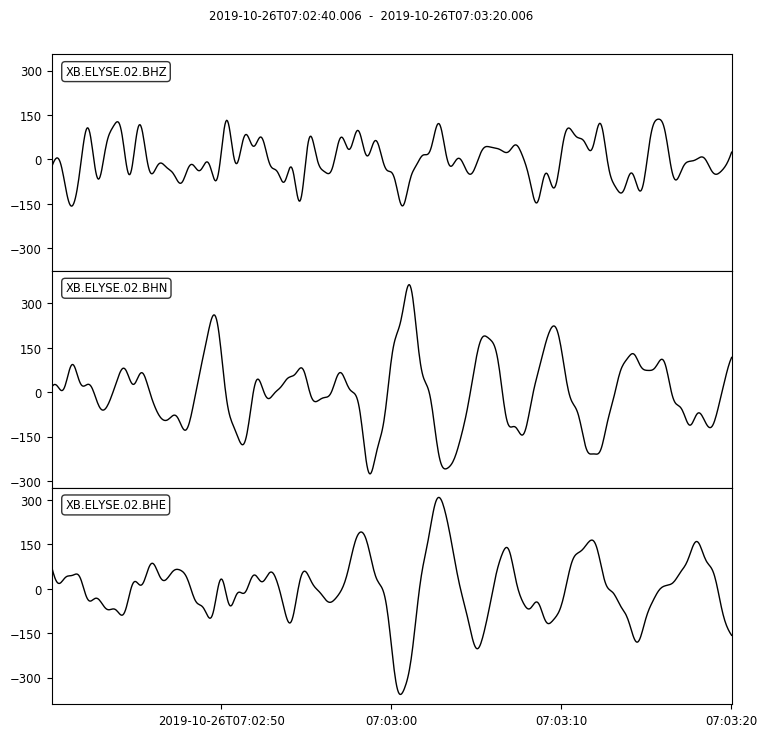

In [15]:
begin = UTCDateTime('2019-10-26T06:59:08')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:03:00')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stzoom = stf.slice(starttime=end-20, endtime=end+20)
stzoom.plot();

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T06:59:07.006000Z - 2019-10-26T06:59:11.006000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHN | 2019-10-26T06:59:07.006000Z - 2019-10-26T06:59:11.006000Z | 20.0 Hz, 81 samples
XB.ELYSE.02.BHZ | 2019-10-26T06:59:07.006000Z - 2019-10-26T06:59:11.006000Z | 20.0 Hz, 81 samples
3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-10-26T07:02:55.006000Z - 2019-10-26T07:03:15.006000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHN | 2019-10-26T07:02:55.006000Z - 2019-10-26T07:03:15.006000Z | 20.0 Hz, 401 samples
XB.ELYSE.02.BHZ | 2019-10-26T07:02:55.006000Z - 2019-10-26T07:03:15.006000Z | 20.0 Hz, 401 samples


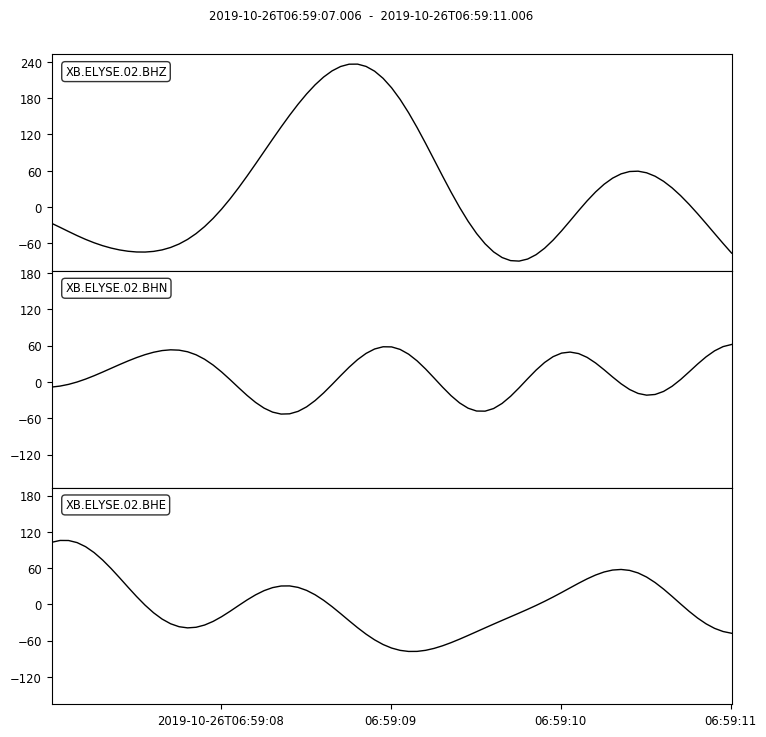

In [16]:
stP = stf.slice(starttime=begin-1,endtime=begin+3)
stS = stf.slice(starttime=end-5, endtime=end+15)
print(stP)
print(stS)
stP.plot();

In [19]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]
print(tval)

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[ 4.65702635  4.68759355  4.71684     4.74473005  4.77122973  4.79630676
  4.81993057  4.8420724   4.86270525  4.881804    4.89934538  4.91530801
  4.92967245  4.94242119  4.95353871  4.96301145  4.97082788  4.97697848
  4.98145574  4.98425422  4.98537051  4.98480324  4.98255311  4.97862286
  4.97301727  4.96574318  4.95680945  4.94622696  4.93400861  4.92016928
  4.90472583  4.88769709  4.86910378  4.84896858  4.82731601  4.80417245
  4.7795661   4.75352693  4.72608667  4.69727876  4.66713829  4.63570198
  4.60300814  4.56909659  4.53400865  4.49778708  4.46047599  4.42212085
  4.38276839  4.34246656  4.30126445  4.25921226  4.21636124  4.17276357
  4.12847239  4.08354166  4.03802611  3.99198119  3.94546302  3.89852826
  3.85123409  3.80363814  3.7557984   3.70777314  3.65962089  3.6114003
  3.56317014  3.51498914  3.46691603  3.41900937  3.37132752  3.32392858
  3.2768703   3.23021001  3.18400455  3.13831023  3.09318272  3.04867699
  3.00484726  2.96174695  2.91942855  2.87794364  2.

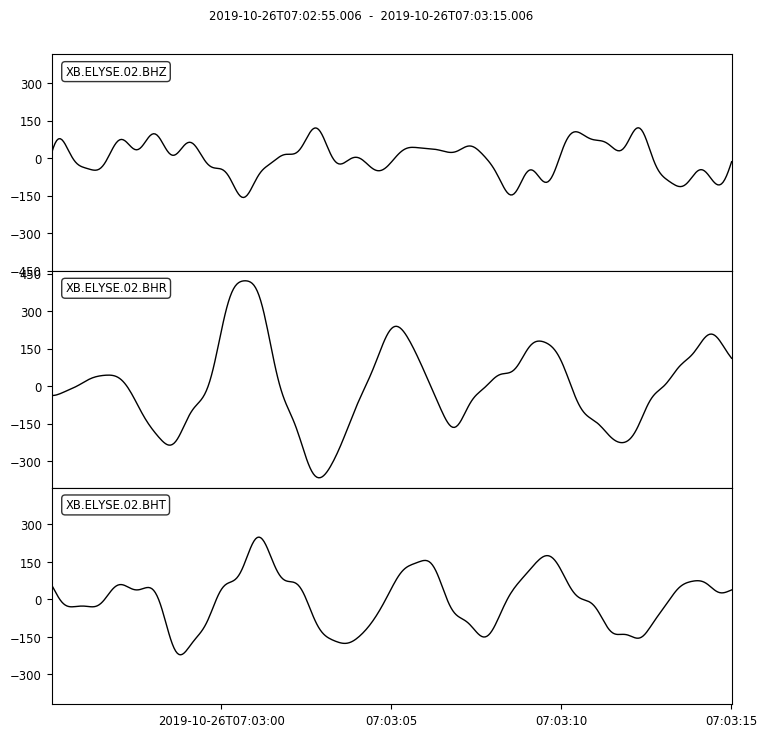

In [18]:
hhe = stS[0].data
hhn = stS[1].data
hhT,hhR = rotate(hhe,hhn,290)

streamRT = stS.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT.plot();